In [7]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim

ru_stopwords = get_stop_words('ru')

In [8]:
df = pd.read_csv('data/parallel.csv') # Параллельный корпус (текст-статьи)
code = pd.read_csv('data/articles.csv') # УК РФ
dictionary = gensim.corpora.Dictionary.load('data/opencorpora/opencorpora.dict') # Известные слова русского языка (из opencorpora)

In [9]:
m = Mystem(entire_input=False)

In [10]:
df['lemmas'] = df['case'].map(lambda text: list(filter(lambda word: word not in ru_stopwords and len(word) > 3, m.lemmatize(text))))
code['lemmas'] = code['lemmas'].map(eval)

In [11]:
code['bow'] = code['lemmas'].map(dictionary.doc2bow)
df['bow'] = df['lemmas'].map(dictionary.doc2bow)

In [13]:
tf_idf = gensim.models.TfidfModel.load('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [17]:
def map_vector(vector, size):
    a = np.zeros(size)
    for n, value in vector:
        a[n] = value
    return a

In [18]:
size = len(dictionary)
code['tfidf'] = code['bow'].map(lambda bow: map_vector(tf_idf[bow], size))
df['tfidf'] = df['bow'].map(lambda bow: map_vector(tf_idf[bow], size))

In [ ]:
from scipy.spatial.distance import cosine

In [35]:
distances = np.zeros((df.shape[0], code.shape[0]))

for i, text in enumerate(df['tfidf'].tolist()):
    for j, article in enumerate(code['tfidf'].tolist()):
        distances[i, j] = cosine(text, article)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
%matplotlib inline

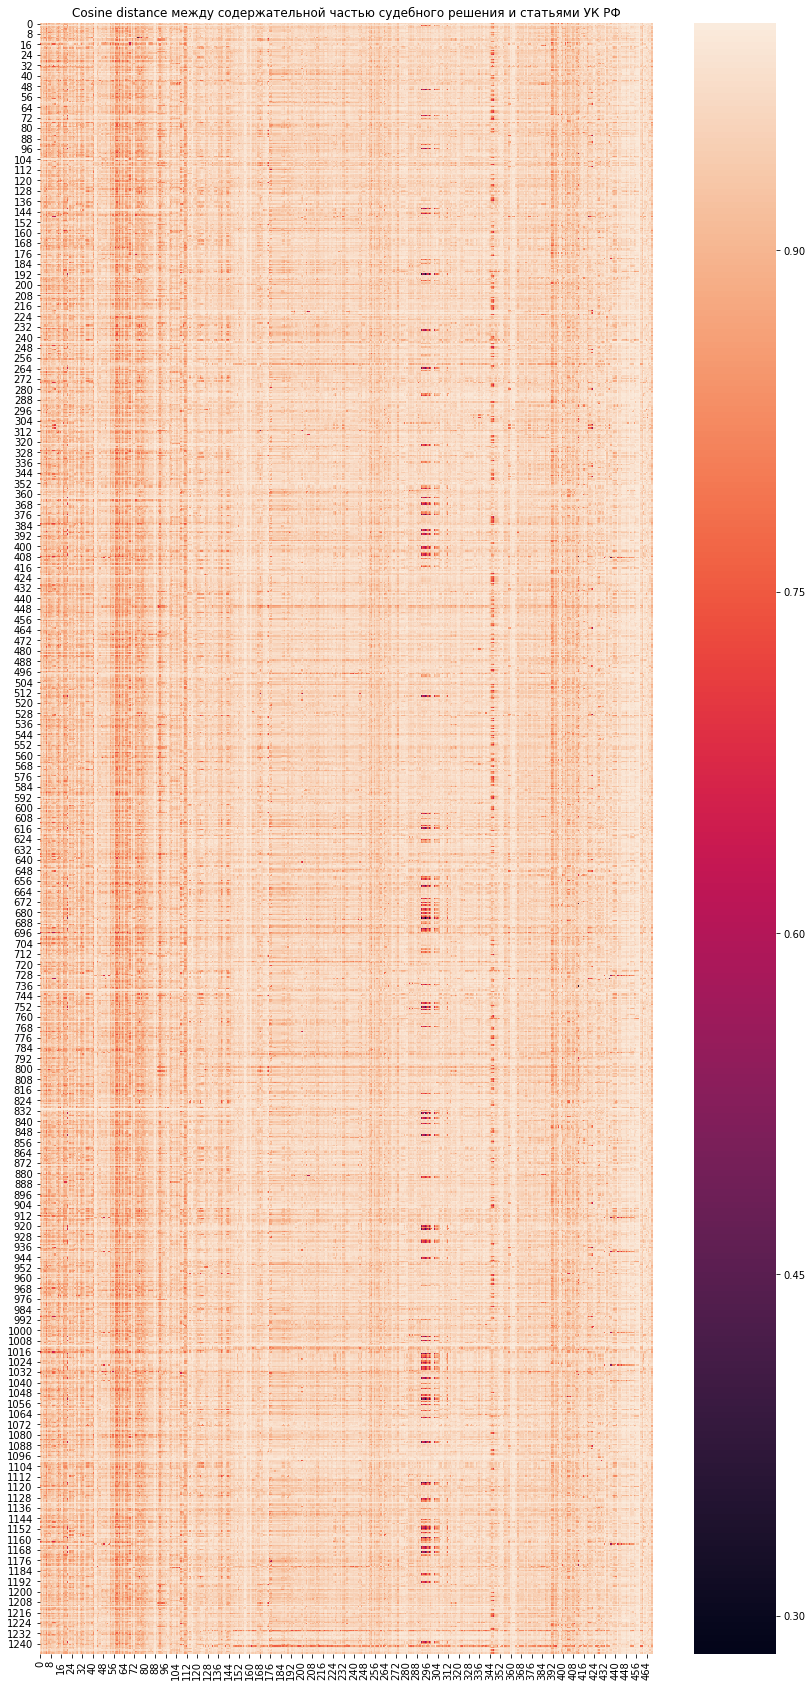

In [130]:
fig, ax = plt.subplots(figsize=(15,30))
ax.set_title('Cosine distance между содержательной частью судебного решения и статьями УК РФ')
ax.set_xlabel('Статьи УК РФ')
ax.set_ylabel('Судебное решение')
ax = sns.heatmap(distances, ax=ax, square=True)

Аномально близкие ко многим делам статьи:

In [142]:
print('\n\n'.join(code.loc[290:300, 'name'].tolist()))

Контрабанда сильнодействующих, ядовитых, отравляющих, взрывчатых, радиоактивных веществ, радиационных источников, ядерных материалов, огнестрельного оружия или его основных частей, взрывных устройств, боеприпасов, оружия массового поражения, средств его доставки, иного вооружения, иной военной техники, а также материалов и оборудования, которые могут быть использованы при создании оружия массового поражения, средств его доставки, иного вооружения, иной военной техники, а равно стратегически важных товаров и ресурсов или культурных ценностей либо особо ценных диких животных и водных биологических ресурсов

Пиратство

Незаконные приобретение, хранение, перевозка, изготовление, переработка наркотических средств, психотропных веществ или их аналогов, а также незаконные приобретение, хранение, перевозка растений, содержащих наркотические средства или психотропные вещества, либо их частей, содержащих наркотические средства или психотропные вещества

Незаконные производство, сбыт или пересылк

In [131]:
num_predictions = 5
for i in range(distances.shape[0]):
    df.loc[i, 'predicted'] = str([code.loc[j, 'number'] for j in distances[i].argsort()[:num_predictions]])

df['predicted'] = df['predicted'].map(eval)
df['labels'] = df['labels'].map(eval)

In [133]:
def intersection(row):
    return len(set(row['labels']).intersection(set(row['predicted'])))

df['intersection'] = df.apply(intersection, axis=1)

In [134]:
def has_intersection(row):
    if len(set(row['labels']).intersection(set(row['predicted']))) > 0:
        return 1
    return 0
df['is_right'] = df.apply(has_intersection, axis=1)

In [135]:
df['is_right'].sum() / df.shape[0]

0.5817307692307693

In [136]:
df[['case', 'labels', 'predicted', 'is_right', 'intersection']].head(15)

,case,labels,predicted,is_right,intersection
0,по постановлению мирового судьи <адрес> района...,"[264.1, 317.0, 389.15]","[300.0, 302.0, 295.0, 264.1, 303.0]",1,1
1,подсудимый городко ф.а. совершил угрозу убийст...,[119.0],"[6.0, 21.0, 22.0, 63.0, 61.0]",0,0
2,"подсудимые березкин с.и., мурсакулов э.а., род...","[33.0, 228.0, 33.0, 228.1, 33.0, 30.0, 228.1, ...","[228.0, 228.3, 229.1, 228.4, 228.2]",1,1
3,"подсудимый лебедев а.в. совершил преступление,...",[264.1],"[264.1, 104.5, 68.0, 104.4, 60.0]",1,1
4,гришанов сергей борисович совершил публичное о...,[319.0],"[6.0, 63.0, 61.0, 43.0, 60.0]",0,0
5,06 июня 2017 года в период времени с 21.30 час...,"[158.0, 73.0]","[22.0, 6.0, 60.0, 61.0, 89.0]",0,0
6,"<фио1> совершил покушение на кражу, то есть та...","[30.0, 158.0, 73.0, 81.0, 317.0]","[61.0, 68.0, 6.0, 64.0, 60.0]",0,0
7,приговором мирового судьи судебного участка № ...,"[264.1, 70.0, 73.0]","[8.0, 264.1, 70.0, 63.0, 21.0]",1,2
8,"<фио6> обвиняется в том, что она совершила пуб...",[319.0],"[63.0, 6.0, 61.0, 89.0, 67.0]",0,0
9,михайлов д.и. управлял автомобилем в состоянии...,"[264.1, 389.15]","[264.1, 70.0, 264.0, 23.0, 295.0]",1,1
